<a id="1"></a> <br>
## Step 1: Reading and Understanding the Data

In [84]:
# import all libraries and dependencies for dataframe

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# import all libraries and dependencies for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# import all libraries and dependencies for clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [85]:
# Reading the country file on which analysis needs to be done

df_ngo = pd.read_csv('Country-data.csv')

df_ngo.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [86]:
df_ngo.shape

(167, 10)

In [87]:
df_ngo.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [88]:
df_ngo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


<a id="2"></a> <br>
## Step 2 : Data Cleansing

We need to do some basic cleansing check in order to feed our model the correct data.

In [89]:
# Calculating the Missing Values % contribution in DF

df_null = df_ngo.isna().mean()*100
df_null

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

#### Inference:
- None of the columns have null values hence no imputation or drop required.

In [90]:
# Datatype check for the dataframe

df_ngo.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

#### Inference:
- None of the columns have inconsistent datatype, hence no conversion is required.

In [91]:
# Duplicates check

df_ngo.loc[df_ngo.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


In [92]:
# Segregation of Numerical and Categorical Variables/Columns

cat_col = df_ngo.select_dtypes(include = ['object']).columns
num_col = df_ngo.select_dtypes(exclude = ['object']).columns

*The dataset seems to be almost clean and hence no such cleansing activities are required.*

<a id="3"></a> <br>
## Step 3 : Data Visualization

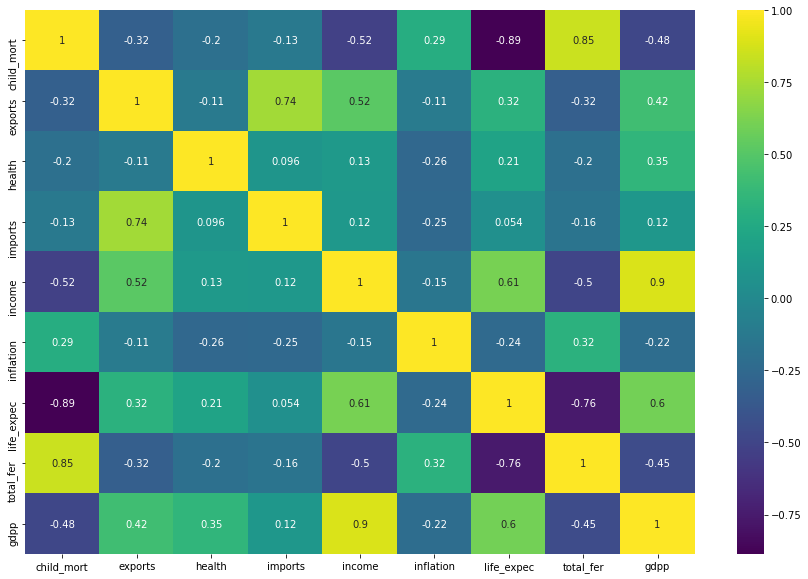

In [93]:
# Heatmap to understand the attributes dependency

plt.figure(figsize = (15,10))        
sns.heatmap(df_ngo.corr(),annot = True,cmap='viridis')
plt.show()

#### Inference:
- `child_mortality` and `life_expectency` are highly correlated with correlation of `-0.89`
- `child_mortality` and `total_fertility` are highly correlated with correlation of `0.85`
- `imports` and `exports` are highly correlated with correlation of `0.74`
- `life_expectency` and `total_fertility` are highly correlated with correlation of `-0.76`

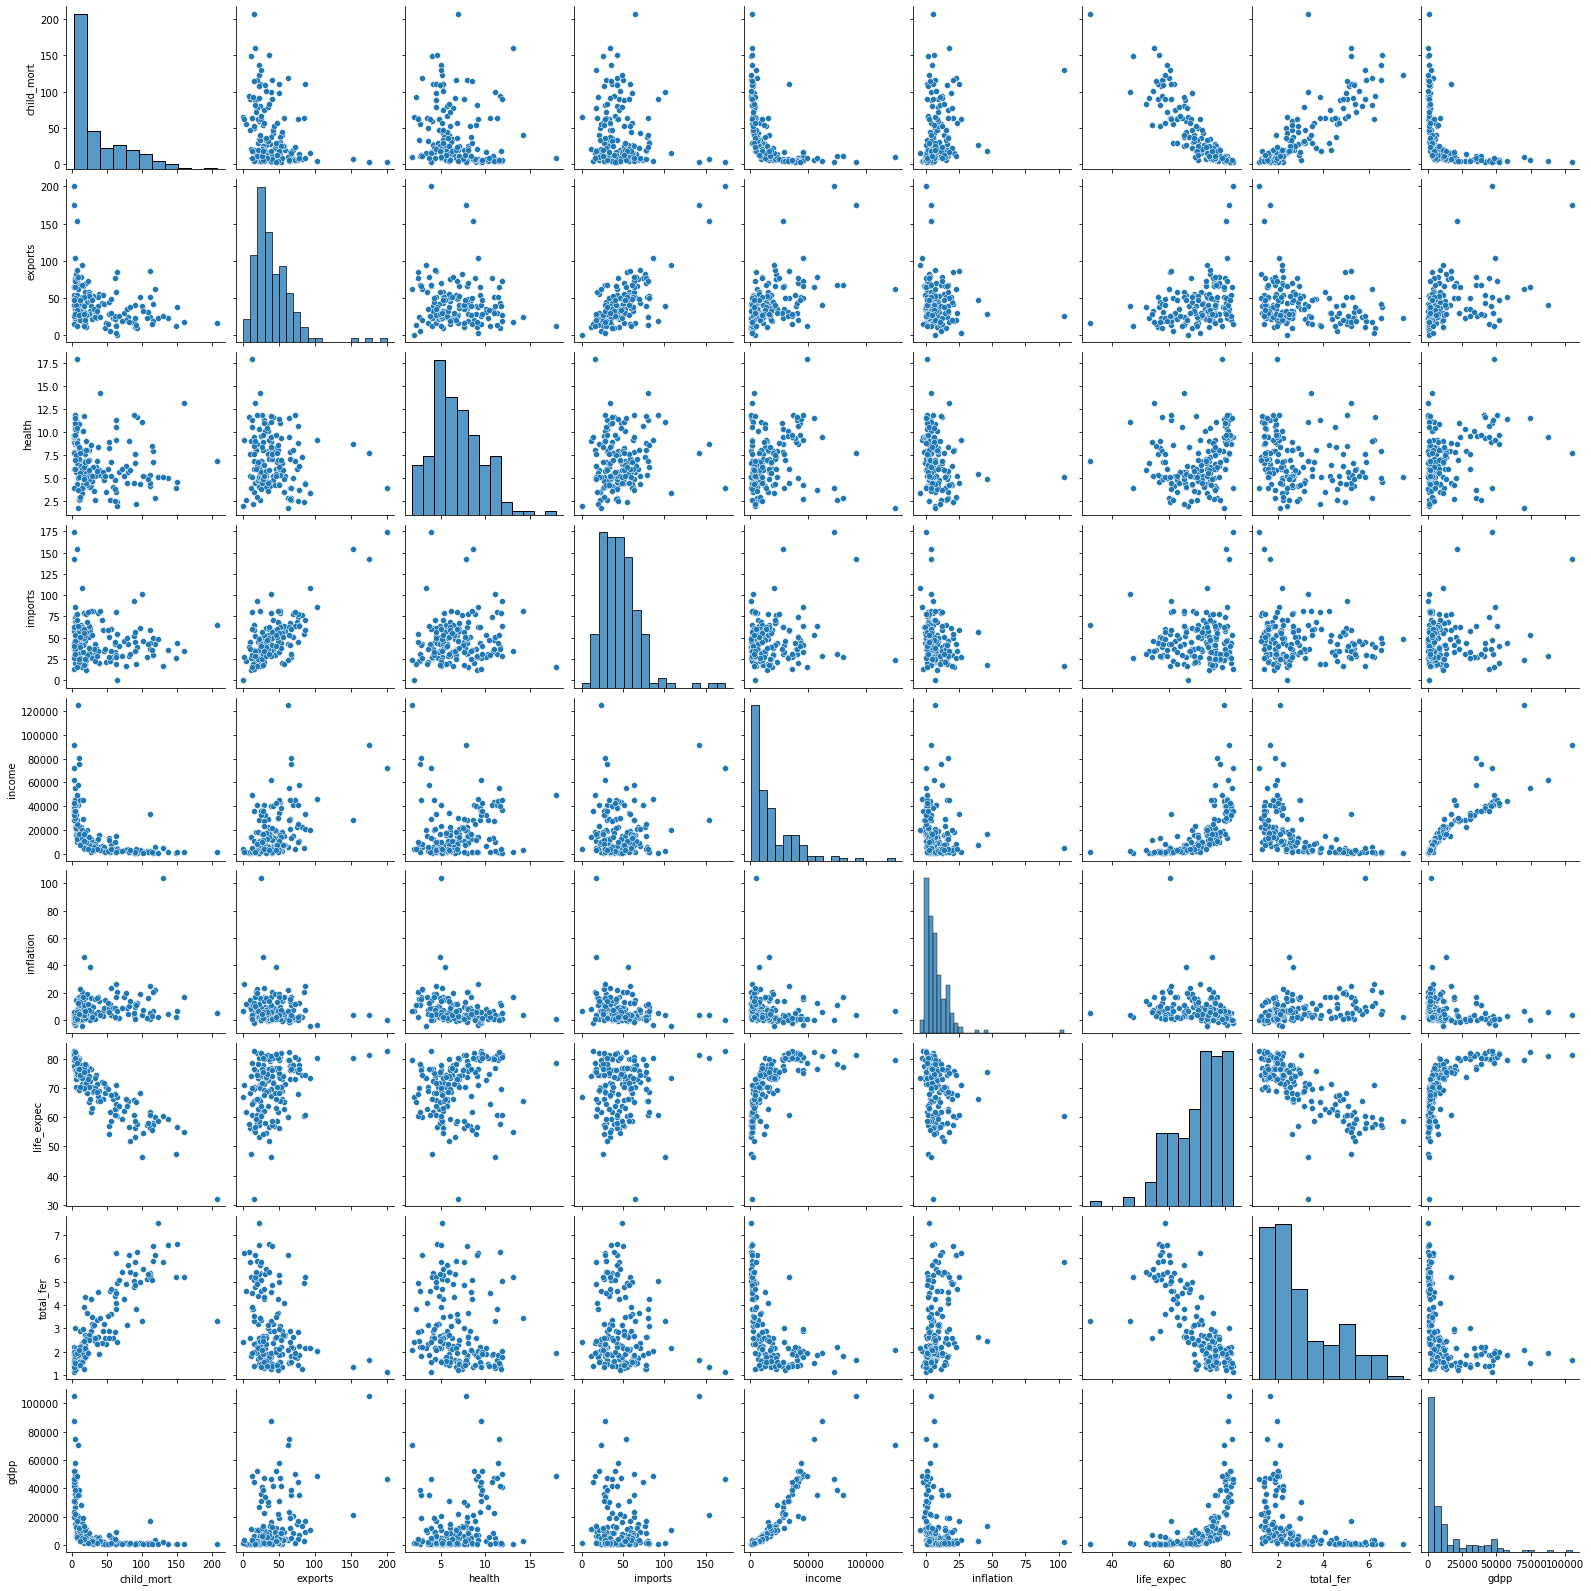

In [94]:
# Pairplot of all numeric columns

sns.pairplot(df_ngo)

<a id="4"></a> <br>
## Step 4 : Data Preparation

**Derived Metrices**<br>

Deducing imports,exports and health spending from percentage values to actual values of their GDP per capita .Because the percentage values don't give a clear picture of that country. For example Austria and Belarus have almost same exports % but their gdpp has a huge gap which doesn't give an accurate idea of which country is more developed than the other.

In [95]:
# Converting exports,imports and health spending percentages to absolute values.

df_ngo['exports'] = df_ngo['exports'] * df_ngo['gdpp']/100
df_ngo['imports'] = df_ngo['imports'] * df_ngo['gdpp']/100
df_ngo['health'] = df_ngo['health'] * df_ngo['gdpp']/100

In [96]:
df_ngo.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [97]:
# Dropping Country field as final dataframe will only contain data columns

df_ngo_drop = df_ngo.copy()
country = df_ngo_drop.pop('country')

In [98]:
df_ngo_drop.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


#### Rescaling the Features
Most software packages use SVD to compute the principal components and assume that the data is scaled and centred, so it is important to do standardisation/normalisation.
There are two common ways of rescaling:

1. Min-Max scaling<br>
2. Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [99]:
# Standarisation technique for scaling

warnings.filterwarnings("ignore")
scaler = StandardScaler()
df_ngo_scaled = scaler.fit_transform(df_ngo_drop)

In [100]:
df_ngo_scaled

array([[ 1.29153238, -0.4110113 , -0.56503989, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.35019096, -0.43921769, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.31852577, -0.48482608, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541, -0.36146329, -0.53848844, ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.39216643, -0.55059641, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.38395214, -0.54049845, ..., -2.09278484,
         1.6246091 , -0.62954556]])

<a id="5"></a> <br>
## Step 5 : PCA Application

Principal component analysis (PCA) is one of the most commonly used `dimensionality reduction` techniques in the industry. By converting large data sets into smaller ones containing fewer variables, it helps in improving model performance, visualising complex data sets, and in many more areas.


In [101]:
pca = PCA(svd_solver='randomized', random_state=42)

In [102]:
# Lets apply PCA on the scaled data

pca.fit(df_ngo_scaled)

PCA(random_state=42, svd_solver='randomized')

In [103]:
# PCA components created 

pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [104]:
# Variance Ratio

pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

Text(0, 0.5, 'Variance Ratio')

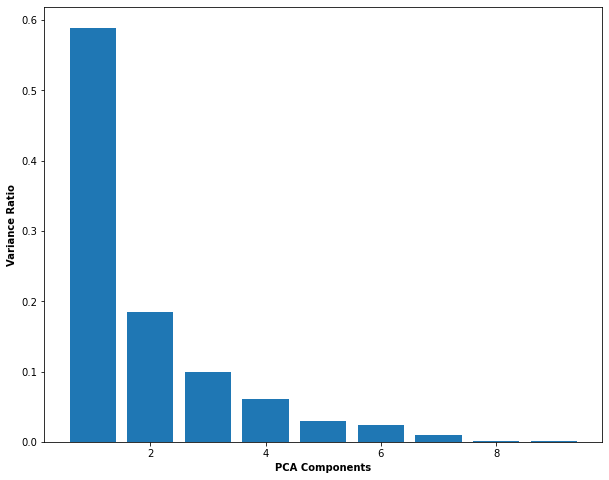

In [105]:
# Variance Ratio bar plot for each PCA components.

plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel("PCA Components",fontweight = 'bold')
plt.ylabel("Variance Ratio",fontweight = 'bold')

#### Inference:
- With first component variance explained is almost 60%.
- For second component variance explained is almost 20%.

Text(0, 0.5, 'Cumulative Explained Variance')

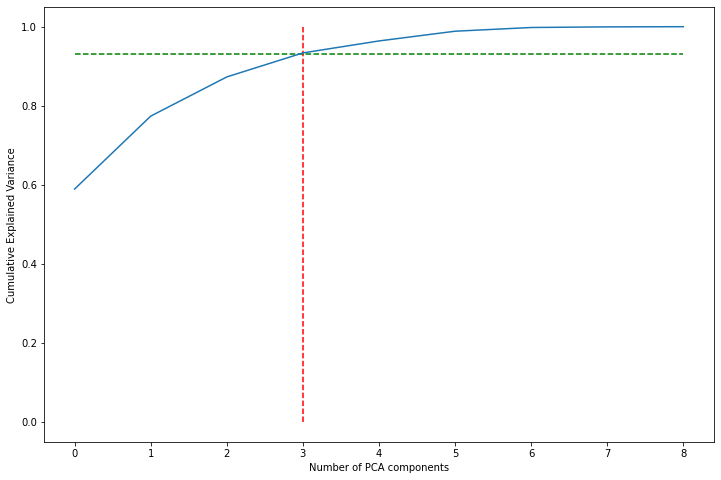

In [106]:
# Scree plot to visualize the Cumulative variance against the Number of components

fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(x=3, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.93, xmax=8, xmin=0, colors="g", linestyles="--")
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')

#### Inference:
It is evident from the above Scree plot that more than 90% variance is explained by the first 3 principal components.
Hence, we will use these components only going forward for Clustering process.

In [107]:
# Checking which attributes are well explained by the pca components

org_col = list(df_ngo.drop(['country'],axis=1).columns)
attributes_pca = pd.DataFrame({'Attribute':org_col,'PC_1':pca.components_[0],'PC_2':pca.components_[1],'PC_3':pca.components_[2]})

In [108]:
attributes_pca

,Attribute,PC_1,PC_2,PC_3
0,child_mort,-0.316392,0.476267,-0.150012
1,exports,0.342887,0.397311,-0.030574
2,health,0.358535,0.155053,-0.075703
3,imports,0.344865,0.370781,-0.072174
4,income,0.380041,0.128384,0.145764
5,inflation,-0.143085,0.221261,0.948419
6,life_expec,0.343857,-0.369820,0.196752
7,total_fer,-0.302842,0.459715,-0.077834
8,gdpp,0.399988,0.200624,0.010339


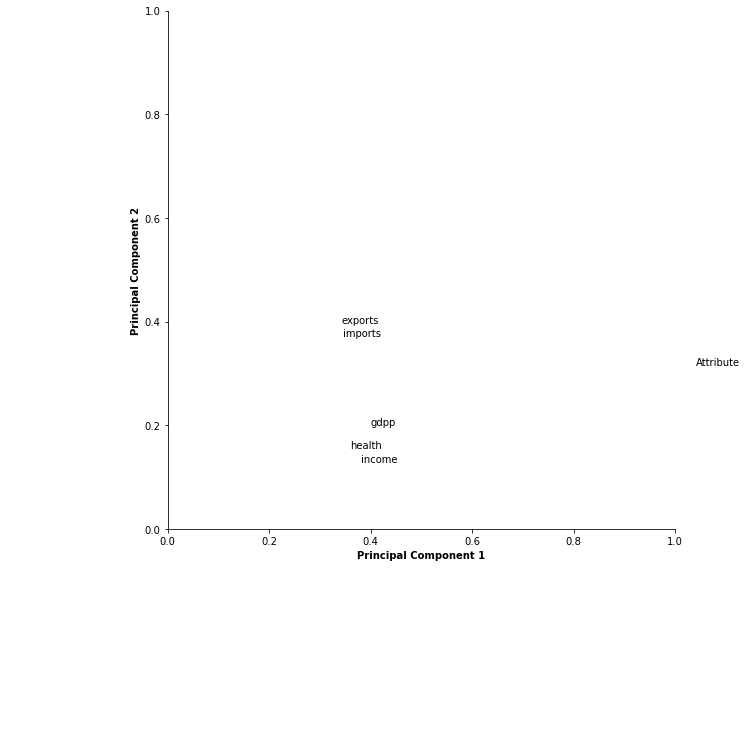

In [109]:
# Plotting the above dataframe for better visualization with PC1 and PC2

sns.pairplot(data=attributes_pca, x_vars=["PC_1"], y_vars=["PC_2"], hue = "Attribute" ,height=8)
plt.xlabel("Principal Component 1",fontweight = 'bold')
plt.ylabel("Principal Component 2",fontweight = 'bold')

for i,txt in enumerate(attributes_pca.Attribute):
    plt.annotate(txt, (attributes_pca.PC_1[i],attributes_pca.PC_2[i]))

#### Inference:
- `life expectency`, `income`, `gdpp` and `health` are very well explained by PC1.
- `imports` and `exports` are well explained by both the components PC1 and PC2.
- `child mortality` and `total fertility` are well explained by PC2.
- `inflation` is neither explained by PC1 nor with PC2

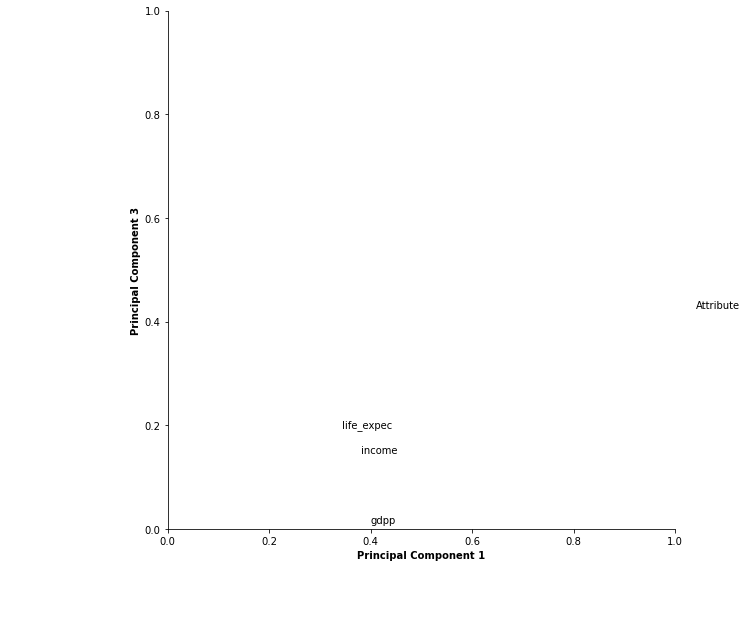

In [110]:
# Plotting the above dataframe with PC1 and PC3 to understand the components which explains inflation.

sns.pairplot(data=attributes_pca, x_vars=["PC_1"], y_vars=["PC_3"], hue = "Attribute" ,height=8)
plt.xlabel("Principal Component 1",fontweight = 'bold')
plt.ylabel("Principal Component 3",fontweight = 'bold')

for i,txt in enumerate(attributes_pca.Attribute):
    plt.annotate(txt, (attributes_pca.PC_1[i],attributes_pca.PC_3[i]))

#### Inference:
- `inflation` is well explained by PC3.

Since 90% variance is explained by 3 principal components, lets build the dataframe using those 3 components only.

In [111]:
# Building the dataframe using Incremental PCA for better efficiency.

inc_pca = IncrementalPCA(n_components=3)

In [112]:
# Fitting the scaled df on incremental pca

df_inc_pca = inc_pca.fit_transform(df_ngo_scaled)
df_inc_pca

array([[-2.63744157e+00,  1.46903797e+00, -5.41359106e-01],
       [-2.22769569e-02, -1.43189586e+00, -2.07009539e-02],
       [-4.57626261e-01, -6.73300938e-01,  9.61867281e-01],
       [-2.72452030e+00,  2.17458267e+00,  6.06686548e-01],
       [ 6.49848516e-01, -1.02437392e+00, -2.50102847e-01],
       [ 3.71968554e-02, -6.80889086e-01,  1.46696276e+00],
       [-3.32691520e-01, -1.27451685e+00,  1.76636110e-01],
       [ 3.18036154e+00, -2.50784878e-01, -1.16877257e-01],
       [ 3.81568156e+00,  2.56083499e-01, -2.70495294e-01],
       [-4.67515152e-01, -4.93492360e-01,  6.03288028e-01],
       [ 1.49875246e+00, -4.28907400e-01, -5.50237572e-01],
       [ 1.47097104e+00, -3.26795693e-01,  4.28411771e-01],
       [-1.01419903e+00, -7.11807758e-01, -1.16988551e-01],
       [ 8.45238116e-01, -1.00860625e+00, -4.17261615e-01],
       [-1.34473920e-02, -9.82186148e-01,  8.80913018e-01],
       [ 3.96087770e+00,  8.38740841e-01, -2.94077196e-01],
       [-4.02707071e-01, -9.21816189e-01

In [113]:
# Creating new dataframe with Principal components

df_pca = pd.DataFrame(df_inc_pca, columns=["PC_1", "PC_2","PC_3"])
df_pca_final = pd.concat([country, df_pca], axis=1)
df_pca_final.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.637442,1.469038,-0.541359
1,Albania,-0.022277,-1.431896,-0.020701
2,Algeria,-0.457626,-0.673301,0.961867
3,Angola,-2.724520,2.174583,0.606687
4,Antigua and Barbuda,0.649849,-1.024374,-0.250103


(3.5, -0.5)

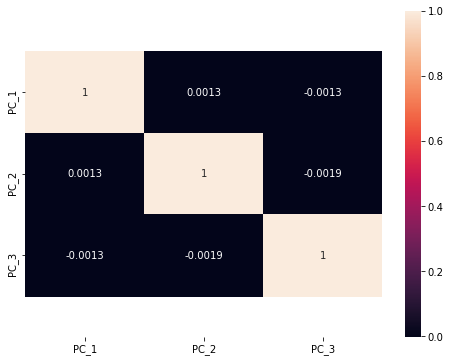

In [114]:
# Plotting Heatmap to check is there still dependency in the dataset.

plt.figure(figsize = (8,6))        
ax = sns.heatmap(df_pca_final.corr(),annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### Inference:
As we can see from above heatmap that the correlation among the attributes is almost `0`, we can proceed with this dataframe.

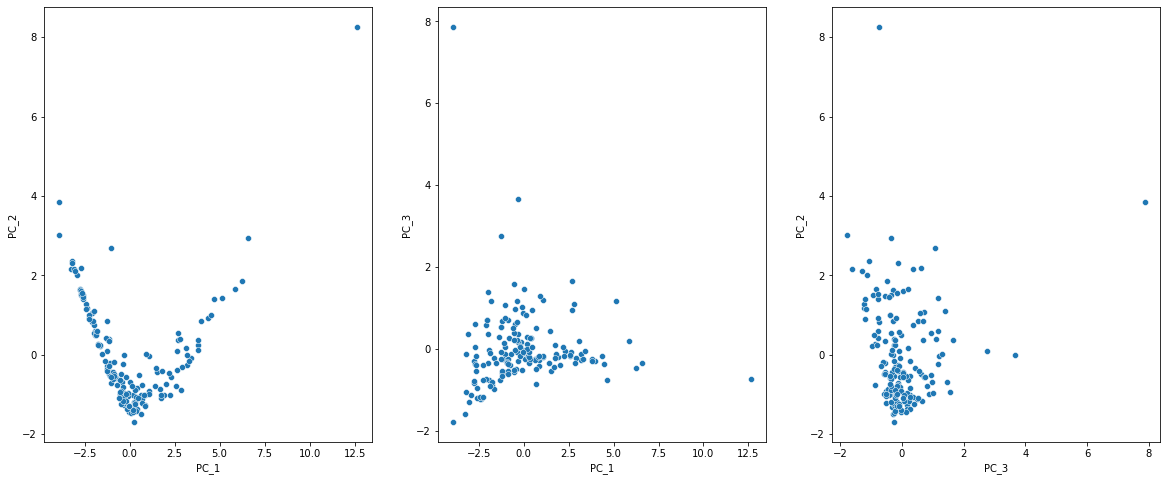

In [115]:
# Scatter Plot to visualize the spread of data across PCA components

plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
sns.scatterplot(data=df_pca_final, x='PC_1', y='PC_2')
plt.subplot(1,3,2)
sns.scatterplot(data=df_pca_final, x='PC_1', y='PC_3')
plt.subplot(1,3,3)
sns.scatterplot(data=df_pca_final, x='PC_3', y='PC_2')
plt.show()

#### Outlier Analysis and Treatment

There are 2 types of outliers and we will treat outliers as it can skew our dataset¶
- Statistical
- Domain specific

Text(0.5, 0, 'PC Components')

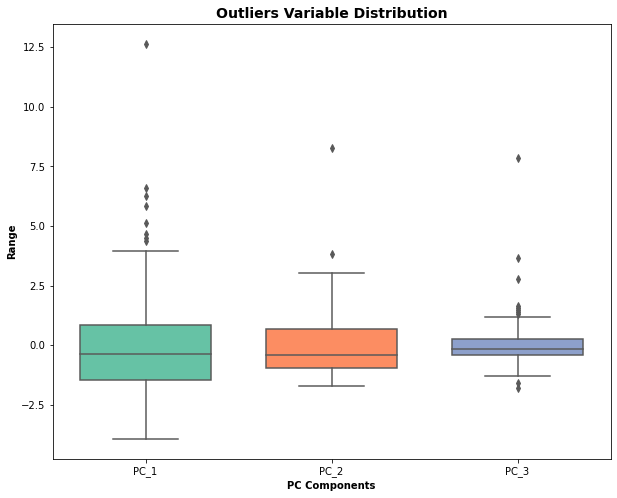

In [116]:
# Outlier Analysis 

outliers = ['PC_1','PC_2','PC_3']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_pca_final[outliers], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("PC Components", fontweight = 'bold')

In [117]:
# Statstical Outlier treatment for PC_1

Q1 = df_pca_final.PC_1.quantile(0.05)
Q3 = df_pca_final.PC_1.quantile(0.95)
IQR = Q3 - Q1
df_pca_final = df_pca_final[(df_pca_final.PC_1 >= Q1) & (df_pca_final.PC_1 <= Q3)]

# Statstical Outlier treatment for PC_2

Q1 = df_pca_final.PC_2.quantile(0.05)
Q3 = df_pca_final.PC_2.quantile(0.95)
IQR = Q3 - Q1
df_pca_final = df_pca_final[(df_pca_final.PC_2 >= Q1) & (df_pca_final.PC_2 <= Q3)]

# Statstical Outlier treatment for PC_3

Q1 = df_pca_final.PC_3.quantile(0.05)
Q3 = df_pca_final.PC_3.quantile(0.95)
IQR = Q3 - Q1
df_pca_final = df_pca_final[(df_pca_final.PC_3 >= Q1) & (df_pca_final.PC_3 <= Q3)]

Text(0.5, 0, 'PC Components')

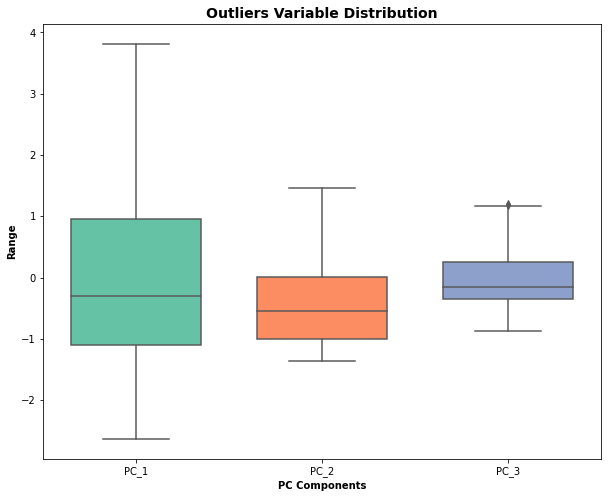

In [118]:
# Plot after Outlier removal 

outliers = ['PC_1','PC_2','PC_3']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_pca_final[outliers], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("PC Components", fontweight = 'bold')

In [119]:
# Reindexing the df after outlier removal

df_pca_final = df_pca_final.reset_index(drop=True)
df_pca_final_data = df_pca_final.drop(['country'],axis=1)
df_pca_final.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.637442,1.469038,-0.541359
1,Algeria,-0.457626,-0.673301,0.961867
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103
3,Armenia,-0.332692,-1.274517,0.176636
4,Australia,3.180362,-0.250785,-0.116877


<a id="7"></a> <br>
## Step  : Model Building

### K- means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:

First we initialize k points, called means, randomly.
We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
We repeat the process for a given number of iterations and at the end, we have our clusters.

**Finding the Optimal Number of Clusters**

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

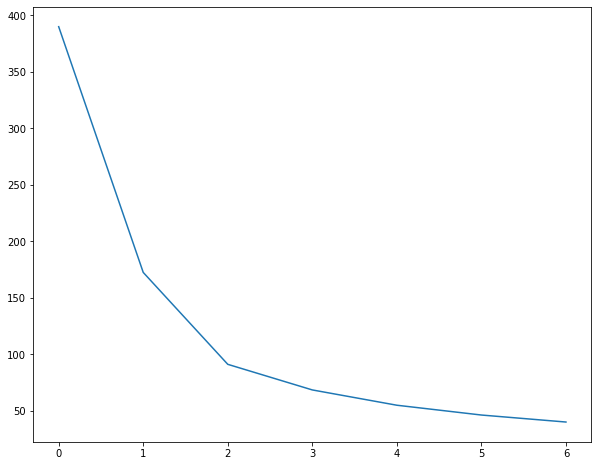

In [120]:
# Elbow curve method to find the ideal number of clusters.
ssd = []
for num_clusters in list(range(1,8)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50,random_state= 100)
    model_clus.fit(df_pca_final_data)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

#### Inference:

Looking at the above elbow curve it looks good to proceed with either 4 or 5 clusters.

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [121]:
# Silhouette score analysis to find the ideal number of clusters for K-means clustering

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state= 100)
    kmeans.fit(df_pca_final_data)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_pca_final_data, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


For n_clusters=2, the silhouette score is 0.4873400103541441
For n_clusters=3, the silhouette score is 0.46397714562182474
For n_clusters=4, the silhouette score is 0.3987356568367148
For n_clusters=5, the silhouette score is 0.3608535370443813
For n_clusters=6, the silhouette score is 0.37147960893483584
For n_clusters=7, the silhouette score is 0.3609446319381151
For n_clusters=8, the silhouette score is 0.34963655749979916


In [122]:
#K-means with k=4 clusters

cluster4 = KMeans(n_clusters=4, max_iter=50, random_state= 100)
cluster4.fit(df_pca_final_data)

KMeans(max_iter=50, n_clusters=4, random_state=100)

In [123]:
# Cluster labels

cluster4.labels_

array([3, 1, 0, 1, 2, 2, 1, 0, 0, 1, 0, 1, 1, 1, 1, 3, 0, 0, 1, 2, 1, 0,
       1, 1, 3, 3, 0, 2, 0, 1, 1, 1, 1, 3, 0, 1, 2, 2, 3, 3, 1, 2, 3, 0,
       1, 1, 1, 0, 2, 1, 1, 1, 3, 0, 2, 1, 2, 1, 1, 3, 2, 1, 3, 0, 3, 0,
       0, 3, 0, 0, 2, 3, 0, 1, 1, 1, 1, 3, 1, 2, 0, 3, 0, 1, 1, 1, 0, 0,
       0, 1, 3, 1, 0, 0, 2, 3, 3, 0, 2, 1, 3, 1, 2, 1, 3, 1, 1, 0, 1, 3,
       1, 2, 2, 2, 0, 1, 1, 1, 3])

In [124]:
# Assign the label

df_pca_final['Cluster_Id4'] = cluster4.labels_
df_pca_final.head()

,country,PC_1,PC_2,PC_3,Cluster_Id4
0,Afghanistan,-2.637442,1.469038,-0.541359,3
1,Algeria,-0.457626,-0.673301,0.961867,1
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103,0
3,Armenia,-0.332692,-1.274517,0.176636,1
4,Australia,3.180362,-0.250785,-0.116877,2


In [125]:
# Number of countries in each cluster

df_pca_final['Cluster_Id4'].value_counts()

1    48
0    29
3    23
2    19
Name: Cluster_Id4, dtype: int64

#### Inference:
It seems there are good number of countries in each clusters.

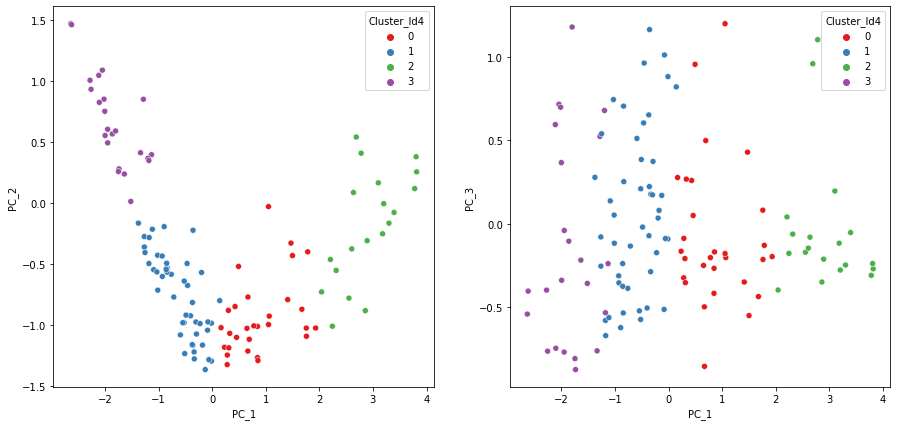

In [126]:
# Scatter plot on Principal components to visualize the spread of the data

fig, axes = plt.subplots(1,2, figsize=(15,7))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id4',legend='full',palette="Set1",data=df_pca_final,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id4',legend='full',palette="Set1",data=df_pca_final,ax=axes[1])
plt.show()

#### Inference:
- In plot 1, it seems lot of intra-distance between the cluster elements, which is not a good sign.

In [127]:
# Lets drop the Cluster Id created with 4 clusters and proceed with 5 clusters.

df_pca_final = df_pca_final.drop('Cluster_Id4',axis=1)

In [128]:
#K-means with k=5 clusters

cluster5 = KMeans(n_clusters=5, max_iter=50,random_state=100)
cluster5.fit(df_pca_final_data)

KMeans(max_iter=50, n_clusters=5, random_state=100)

In [129]:
# Cluster labels

cluster5.labels_

array([1, 0, 3, 0, 2, 2, 0, 3, 3, 4, 3, 0, 4, 4, 4, 1, 0, 0, 4, 2, 4, 0,
       0, 0, 1, 1, 3, 2, 3, 0, 0, 4, 0, 1, 3, 4, 2, 2, 1, 1, 0, 2, 1, 3,
       0, 4, 4, 3, 2, 4, 4, 0, 1, 3, 2, 0, 2, 4, 0, 1, 2, 4, 1, 3, 1, 0,
       3, 1, 0, 0, 2, 1, 0, 4, 0, 4, 4, 1, 4, 2, 0, 1, 0, 0, 0, 4, 3, 3,
       0, 0, 1, 4, 3, 3, 3, 1, 1, 3, 3, 0, 1, 0, 2, 4, 1, 4, 0, 0, 4, 1,
       0, 2, 2, 2, 0, 4, 4, 0, 1])

In [130]:
# assign the label

df_pca_final['Cluster_Id'] = cluster5.labels_
df_pca_final.head()

,country,PC_1,PC_2,PC_3,Cluster_Id
0,Afghanistan,-2.637442,1.469038,-0.541359,1
1,Algeria,-0.457626,-0.673301,0.961867,0
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103,3
3,Armenia,-0.332692,-1.274517,0.176636,0
4,Australia,3.180362,-0.250785,-0.116877,2


In [131]:
# Number of countries in each cluster

df_pca_final['Cluster_Id'].value_counts()

0    35
4    25
1    23
3    19
2    17
Name: Cluster_Id, dtype: int64

#### Inference:
It seems there are good number of countries in each clusters.

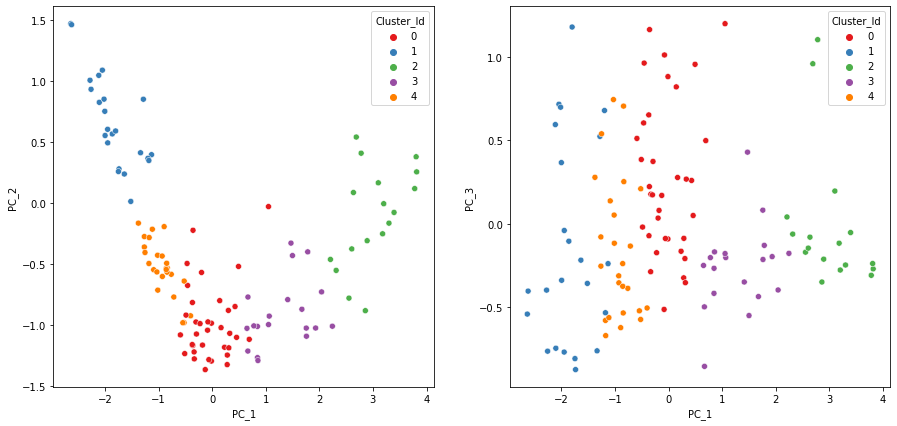

In [132]:
# Scatter plot on Principal components to visualize the spread of the data
fig, axes = plt.subplots(1,2, figsize=(15,7))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id',legend='full',palette="Set1",data=df_pca_final,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id',legend='full',palette="Set1",data=df_pca_final,ax=axes[1])
plt.show()

#### Inference:
- Here also we got the same issue as with 4 clusters but we got a new segment, so lets proceed with K means using 5 clusters.

We have visualized the data on the principal components and saw some good clusters were formed but some were not so good hence let's now visualize the data on the original attributes.

In [133]:
# Merging the df with PCA with original df

df_merge = pd.merge(df_ngo,df_pca_final,on='country')
df_merge_col = df_merge[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','Cluster_Id']]

# Creating df with mean values
cluster_child = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).child_mort.mean())
cluster_export = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).exports.mean())
cluster_import = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).imports.mean())
cluster_health = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).health.mean())
cluster_income = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).income.mean())
cluster_inflation = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).inflation.mean())         
cluster_lifeexpec = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).life_expec.mean())
cluster_totalfer = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).total_fer.mean())
cluster_gdpp = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).gdpp.mean())

df_concat = pd.concat([pd.Series([0,1,2,3,4]),cluster_child,cluster_export,cluster_import,cluster_health,cluster_income
                       ,cluster_inflation,cluster_lifeexpec,cluster_totalfer,cluster_gdpp], axis=1)
df_concat.columns = ["Cluster_Id", "Child_Mortality", "Exports", "Imports","Health_Spending","Income","Inflation","Life_Expectancy","Total_Fertility","GDPpcapita"]
df_concat.head()

,Cluster_Id,Child_Mortality,Exports,Imports,Health_Spending,Income,Inflation,Life_Expectancy,Total_Fertility,GDPpcapita
0,0,17.900000,2934.328857,2790.207714,417.946200,14125.714286,8.258286,74.054286,2.085429,6943.428571
1,1,68.478261,884.774513,838.634174,135.873852,4650.869565,10.711304,62.169565,4.507391,2152.739130
2,2,5.141176,16736.111765,15324.935294,3954.500588,41705.882353,2.823647,80.476471,1.776471,40911.764706
3,3,6.900000,9200.489474,9445.805263,1489.787895,25036.842105,0.904789,76.957895,1.678947,18810.526316
4,4,37.216000,931.788741,1241.580044,130.351536,5442.800000,6.602040,69.232000,2.982000,2416.880000


In [134]:
df_merge_col.head(5)

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2,55.30,248.297,41.9174,1610,9.44,56.2,5.82,553,1
1,Algeria,27.3,1712.64,1400.440,185.9820,12900,16.10,76.5,2.89,4460,0
2,Antigua and Barbuda,10.3,5551.00,7185.800,735.6600,19100,1.44,76.8,2.13,12200,3
3,Armenia,18.1,669.76,1458.660,141.6800,6700,7.77,73.3,1.69,3220,0
4,Australia,4.8,10276.20,10847.100,4530.8700,41400,1.16,82.0,1.93,51900,2


From the business understanding we have learnt that `Child_Mortality`, `Income`, `Gdpp` are some important factors which decides the development of any country.
We have also cross checked with Principal components and found that these variables have good score in PCA.
Hence, we will proceed with analyzing these 3 components to build some meaningful clusters.

<AxesSubplot:xlabel='child_mort', ylabel='gdpp'>

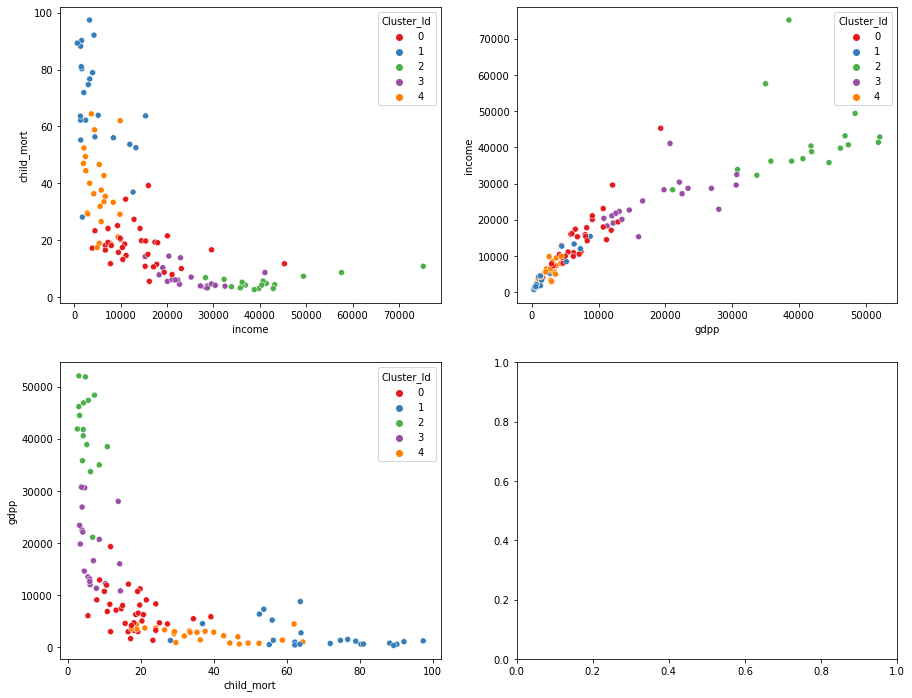

In [135]:
# Scatter plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.scatterplot(x = 'income', y = 'child_mort',hue='Cluster_Id',data = df_merge_col,legend='full',palette="Set1",ax=axes[0][0])
sns.scatterplot(x = 'gdpp', y = 'income',hue='Cluster_Id', data = df_merge_col,legend='full',palette="Set1",ax=axes[0][1])
sns.scatterplot(x = 'child_mort', y = 'gdpp',hue='Cluster_Id', data=df_merge_col,legend='full',palette="Set1",ax=axes[1][0])

<AxesSubplot:xlabel='Cluster_Id', ylabel='gdpp'>

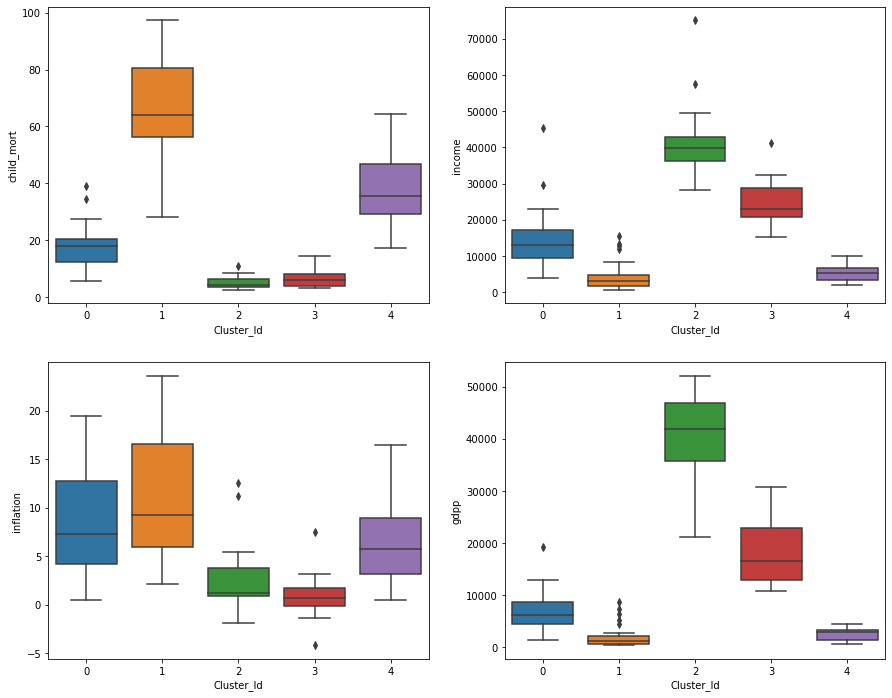

In [136]:
# Box plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(x = 'Cluster_Id', y = 'child_mort', data = df_merge_col,ax=axes[0][0])
sns.boxplot(x = 'Cluster_Id', y = 'income', data = df_merge_col,ax=axes[0][1])
sns.boxplot(x = 'Cluster_Id', y = 'inflation', data=df_merge_col,ax=axes[1][0])
sns.boxplot(x = 'Cluster_Id', y = 'gdpp', data=df_merge_col,ax=axes[1][1])

#### Inference:
- Child Mortality is highest for Cluster `0`  and Cluster `3`.These clusters need some aid.
- Income and Gdpp are measures of development. Higher the per capita income and gdpp better is the country's development.
  Income per capita and gdpp seems lowest for countries in clusters `0` and `3`. Hence, these countries need some help.

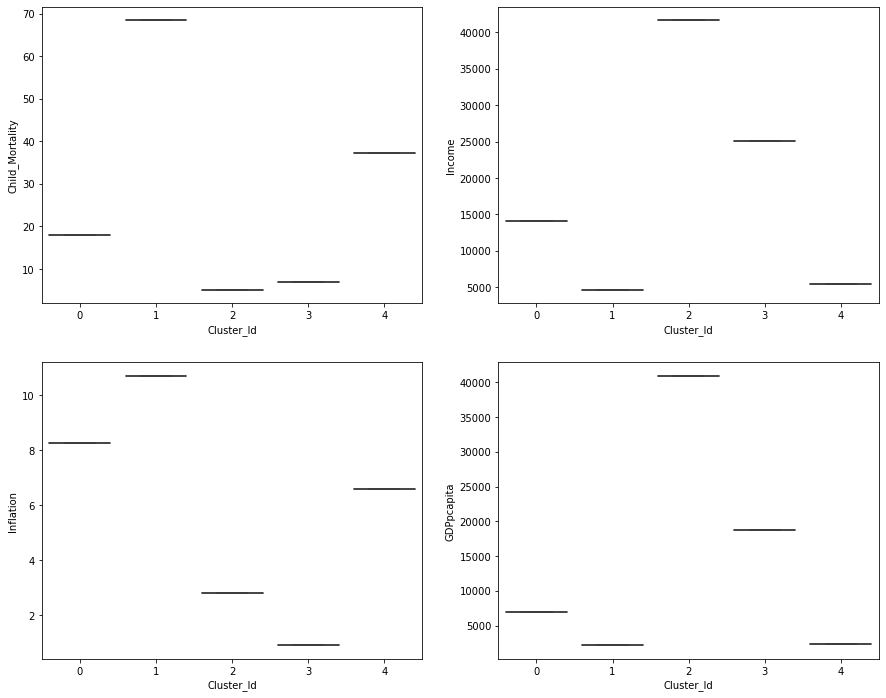

In [137]:
# Box plot to visualise the mean value of few original attributes.

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(x = 'Cluster_Id', y = 'Child_Mortality', data = df_concat,ax=axes[0][0])
sns.boxplot(x = 'Cluster_Id', y = 'Income', data = df_concat,ax=axes[0][1])
sns.boxplot(x = 'Cluster_Id', y = 'Inflation', data=df_concat,ax=axes[1][0])
sns.boxplot(x = 'Cluster_Id', y = 'GDPpcapita', data=df_concat,ax=axes[1][1])
plt.show()

#### Inference:
The mean values suggests the same story as above

In [138]:
# List of countries in Cluster 0

df_merge_col[df_merge_col['Cluster_Id']==0]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
1,Algeria,27.3,1712.64,1400.44,185.982,12900,16.10,76.5,2.89,4460,0
3,Armenia,18.1,669.76,1458.66,141.680,6700,7.77,73.3,1.69,3220,0
6,Azerbaijan,39.2,3171.12,1208.88,343.392,16000,13.80,69.1,1.92,5840,0
11,Belarus,5.5,3099.42,3889.35,338.283,16200,15.10,70.4,1.49,6030,0
16,Brazil,19.8,1198.40,1321.60,1009.120,14500,8.41,74.2,1.80,11200,0
17,Bulgaria,10.8,3433.68,3625.20,469.908,15300,1.11,73.9,1.57,6840,0
21,Chile,8.7,4863.30,4037.70,1026.840,19400,8.96,79.1,1.88,12900,0
22,China,15.7,1199.28,1030.56,231.192,9530,6.94,74.6,1.59,4560,0
23,Colombia,18.6,993.75,1112.50,474.375,10900,3.86,76.4,2.01,6250,0
29,Dominican Republic,34.4,1237.15,1814.85,338.990,11100,5.44,74.6,2.60,5450,0


In [139]:
# List of countries in Cluster 3

df_merge_col[df_merge_col['Cluster_Id']==3]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
2,Antigua and Barbuda,10.3,5551.0,7185.8,735.66,19100,1.440,76.8,2.13,12200,3
7,Bahamas,13.8,9800.0,12236.0,2209.20,22900,-0.393,73.8,1.86,28000,3
8,Bahrain,8.6,14386.5,10536.3,1028.79,41100,7.440,76.0,2.16,20700,3
10,Barbados,14.2,6320.0,7792.0,1275.20,15300,0.321,76.7,1.78,16000,3
26,Croatia,5.5,5076.0,5143.5,1047.60,20100,0.821,76.3,1.55,13500,3
28,Czech Republic,3.4,13068.0,12454.2,1560.24,28300,-1.430,77.5,1.51,19800,3
34,Estonia,4.5,10964.6,10030.2,880.38,22700,1.740,76.0,1.72,14600,3
43,Greece,3.9,5944.9,8258.3,2770.70,28700,0.673,80.4,1.48,26900,3
47,Hungary,6.0,10715.8,10021.5,960.23,22300,2.330,74.5,1.25,13100,3
53,Israel,4.6,10710.0,10067.4,2334.78,29600,1.770,81.4,3.03,30600,3


Now lets apply Hierarchial Clustering to see if we get any better clusters or not.

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,

- Divisive
- Agglomerative.

In [140]:
df_pca_final_data.head()

,PC_1,PC_2,PC_3
0,-2.637442,1.469038,-0.541359
1,-0.457626,-0.673301,0.961867
2,0.649849,-1.024374,-0.250103
3,-0.332692,-1.274517,0.176636
4,3.180362,-0.250785,-0.116877


**Single Linkage:<br>**

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.
![](https://www.saedsayad.com/images/Clustering_single.png)

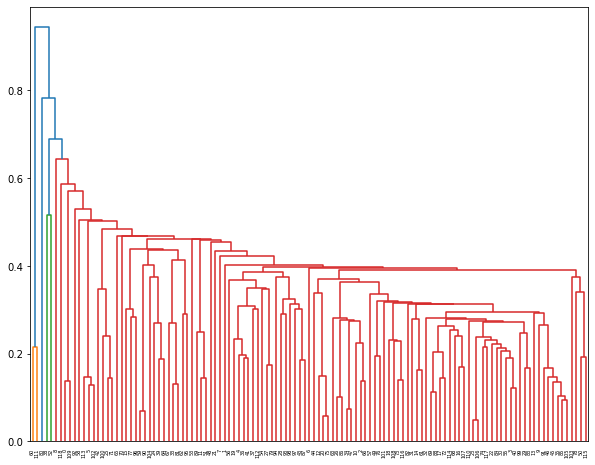

In [141]:
# Single linkage

mergings = linkage(df_pca_final_data, method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage<br>**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points. 
![](https://www.saedsayad.com/images/Clustering_complete.png)

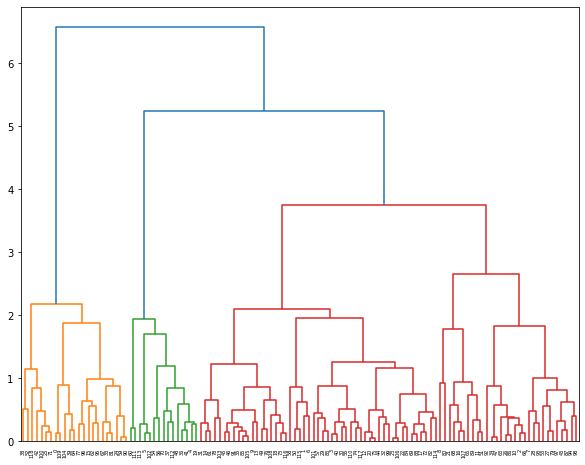

In [142]:
# Complete Linkage

mergings = linkage(df_pca_final_data, method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

In [143]:
df_pca_hc = df_pca_final.copy()
df_pca_hc = df_pca_hc.drop('Cluster_Id',axis=1)
df_pca_hc.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.637442,1.469038,-0.541359
1,Algeria,-0.457626,-0.673301,0.961867
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103
3,Armenia,-0.332692,-1.274517,0.176636
4,Australia,3.180362,-0.250785,-0.116877


In [144]:
# Let cut the tree at height of approx 3 to get 4 clusters and see if it get any better cluster formation.

clusterCut = pd.Series(cut_tree(mergings, n_clusters = 4).reshape(-1,))
df_hc = pd.concat([df_pca_hc, clusterCut], axis=1)
df_hc.columns = ['country', 'PC_1', 'PC_2','PC_3','Cluster_Id']

In [145]:
df_hc.head()

,country,PC_1,PC_2,PC_3,Cluster_Id
0,Afghanistan,-2.637442,1.469038,-0.541359,0
1,Algeria,-0.457626,-0.673301,0.961867,1
2,Antigua and Barbuda,0.649849,-1.024374,-0.250103,2
3,Armenia,-0.332692,-1.274517,0.176636,1
4,Australia,3.180362,-0.250785,-0.116877,3


<AxesSubplot:xlabel='PC_1', ylabel='PC_3'>

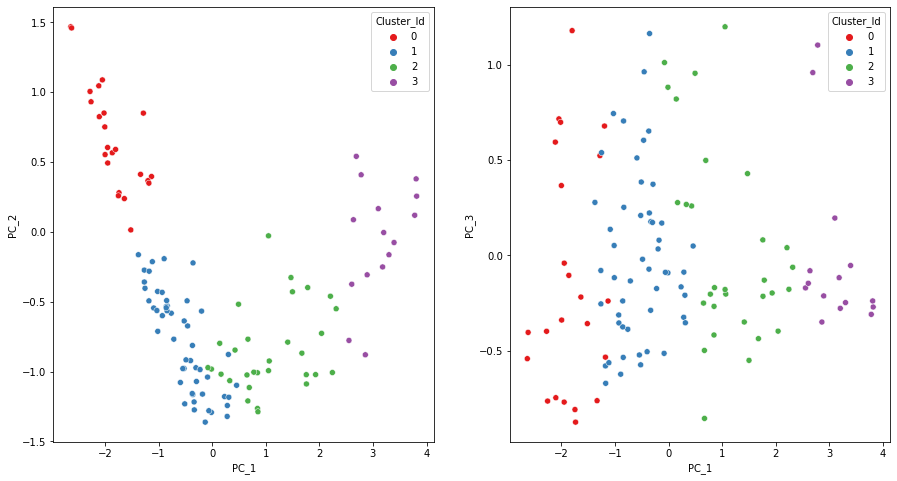

In [146]:
# Scatter plot on Principal components to visualize the spread of the data

fig, axes = plt.subplots(1,2, figsize=(15,8))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id',legend='full',palette="Set1",data=df_hc,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id',legend='full',palette="Set1",data=df_hc,ax=axes[1])

#### Inference:
Cluster `4` seems to be not properly formed in Plot 1.

In [147]:
# Merging the df with PCA with original df

df_merge_hc = pd.merge(df_ngo,df_hc,on='country')
df_merge_col_hc = df_merge[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','Cluster_Id']]

In [148]:
df_merge_col_hc.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2,55.30,248.297,41.9174,1610,9.44,56.2,5.82,553,1
1,Algeria,27.3,1712.64,1400.440,185.9820,12900,16.10,76.5,2.89,4460,0
2,Antigua and Barbuda,10.3,5551.00,7185.800,735.6600,19100,1.44,76.8,2.13,12200,3
3,Armenia,18.1,669.76,1458.660,141.6800,6700,7.77,73.3,1.69,3220,0
4,Australia,4.8,10276.20,10847.100,4530.8700,41400,1.16,82.0,1.93,51900,2


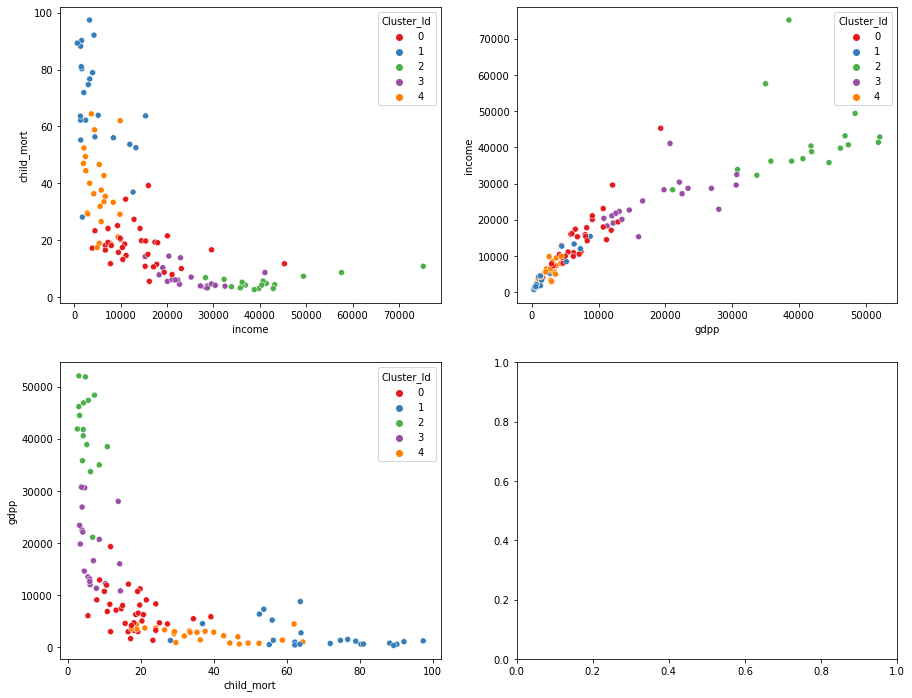

In [149]:
# Scatter plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.scatterplot(x = 'income', y = 'child_mort',hue='Cluster_Id',data = df_merge_col_hc,legend='full',palette="Set1",ax=axes[0][0])
sns.scatterplot(x = 'gdpp', y = 'income',hue='Cluster_Id', data = df_merge_col_hc,legend='full',palette="Set1",ax=axes[0][1])
sns.scatterplot(x = 'child_mort', y = 'gdpp',hue='Cluster_Id', data=df_merge_col_hc,legend='full',palette="Set1",ax=axes[1][0])
plt.show()

**We have analyzed both K-means and Hierarchial clustering and found clusters formed are not identical.
The clusters formed in both the cases are not that great but its better in K-means as compared to Hierarchial.
So, we will proceed with the clusters formed by K-means and based on the information provided by the final clusters we will deduce the final list of countries which are in need of aid.**

<a id="8"></a> <br>
## Step 8 : Final Analysis

We got Cluster `0` and Cluster `3` which are in need of aid.

In [150]:
df_clus0 = df_merge_col[df_merge_col['Cluster_Id'] ==0]

In [151]:
df_clus3 = df_merge_col[df_merge_col['Cluster_Id'] ==3]

In [152]:
# List of countries which need help

df_append= df_clus0.append(df_clus3)

In [153]:
df_append.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
1,Algeria,27.3,1712.64,1400.44,185.982,12900,16.10,76.5,2.89,4460,0
3,Armenia,18.1,669.76,1458.66,141.680,6700,7.77,73.3,1.69,3220,0
6,Azerbaijan,39.2,3171.12,1208.88,343.392,16000,13.80,69.1,1.92,5840,0
11,Belarus,5.5,3099.42,3889.35,338.283,16200,15.10,70.4,1.49,6030,0
16,Brazil,19.8,1198.40,1321.60,1009.120,14500,8.41,74.2,1.80,11200,0


In [154]:
df_append.describe()

,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,14.029630,5139.089074,5131.992037,795.075685,17964.814815,5.670944,75.075926,1.942407,11118.888889,1.055556
std,8.036934,4098.754855,3823.628193,709.033313,8918.765618,5.544451,3.169307,0.479166,7561.114190,1.446096
min,3.200000,638.960000,1030.560000,89.604000,3910.000000,-4.210000,68.400000,1.230000,1310.000000,0.000000
25%,7.200000,1613.957500,1588.022500,338.459750,10600.000000,1.207500,73.325000,1.555000,5547.500000,0.000000
50%,14.000000,4052.470000,3757.695000,477.187500,17250.000000,4.150000,74.650000,1.900000,9070.000000,0.000000
75%,19.175000,7834.125000,8035.900000,1005.252500,22600.000000,8.515000,76.775000,2.215000,13400.000000,3.000000
max,39.200000,15046.200000,14718.600000,2928.780000,45300.000000,19.500000,81.900000,3.030000,30700.000000,3.000000


We have removed few countries during outlier treatment but we might have dropped some countries which might be in need of help.
Let's iterate our final list based on the information from the clusters which were in need of aid.ie, `Cluster 3` and `Cluster 4`

In [155]:
# Based on final clusters information we are going to deduce the final list.
# We observed that mean child mortality is 53 for the selected clusters and hence 
# let's take all the countries with more than this child mortality .

df_final_list = df_ngo[df_ngo['child_mort']>53]
df_final_list.shape

(48, 10)

In [156]:
# Let's check the demographic of the resultant data again

df_final_list.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.00000
mean,93.020833,848.153665,97.516423,754.169835,3695.062500,11.619479,59.550000,4.912083,1797.50000
std,32.420397,2266.219395,149.219608,1509.623708,5325.996802,15.406371,6.552635,1.148607,2852.82954
min,53.700000,1.076920,12.821200,0.651092,609.000000,0.885000,32.100000,2.410000,231.00000
25%,63.850000,101.630250,31.969950,188.805500,1390.000000,3.792500,56.725000,4.345000,551.50000
50%,89.750000,188.290000,48.726500,313.857000,1900.000000,8.215000,60.250000,5.055000,932.00000
75%,111.000000,417.915000,72.785000,571.837500,3785.000000,16.225000,63.850000,5.597500,1377.50000
max,208.000000,14671.800000,766.080000,10071.900000,33700.000000,104.000000,71.100000,7.490000,17100.00000


In [157]:
# We observed that mean income is 3695 for the selected clusters and hence 
# let's take all the countries with less than this income .

df_final_list1 = df_final_list[df_final_list['income']<=3695]
df_final_list1.shape

(35, 10)

In [158]:
# Let's check the demographic of the resultant data again

df_final_list1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,98.720000,190.761400,56.936277,352.976029,1735.800000,8.491286,58.377143,5.252571,831.200000
std,32.886988,159.715094,56.727776,280.167208,769.189482,6.690649,6.957057,0.897743,606.557199
min,55.200000,20.605200,12.821200,90.552000,609.000000,0.885000,32.100000,3.300000,231.000000
25%,75.700000,80.351500,31.512200,170.534000,1215.000000,2.790000,56.250000,4.810000,470.500000
50%,90.500000,131.985000,41.917400,254.560000,1540.000000,6.390000,58.700000,5.210000,648.000000
75%,112.500000,224.584500,57.857500,400.286500,2135.000000,12.200000,62.000000,5.765000,1085.000000
max,208.000000,617.320000,328.320000,1190.510000,3370.000000,26.500000,71.100000,7.490000,3600.000000


In [159]:
# We observed that mean gdpp is 831 for the selected clusters and hence 
# let's take all the countries with less than this gdpp .

df_final_list2 = df_final_list1[df_final_list1['gdpp']<=831]
df_final_list2.shape

(23, 10)

#### Final List of countries which are in need of the aid based on socio-economic factors.

In [160]:
df_final_list2['country']

0                   Afghanistan
17                        Benin
25                 Burkina Faso
26                      Burundi
31     Central African Republic
36                      Comoros
37             Congo, Dem. Rep.
50                      Eritrea
56                       Gambia
63                       Guinea
64                Guinea-Bissau
66                        Haiti
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
106                  Mozambique
112                       Niger
126                      Rwanda
132                Sierra Leone
147                    Tanzania
150                        Togo
155                      Uganda
Name: country, dtype: object

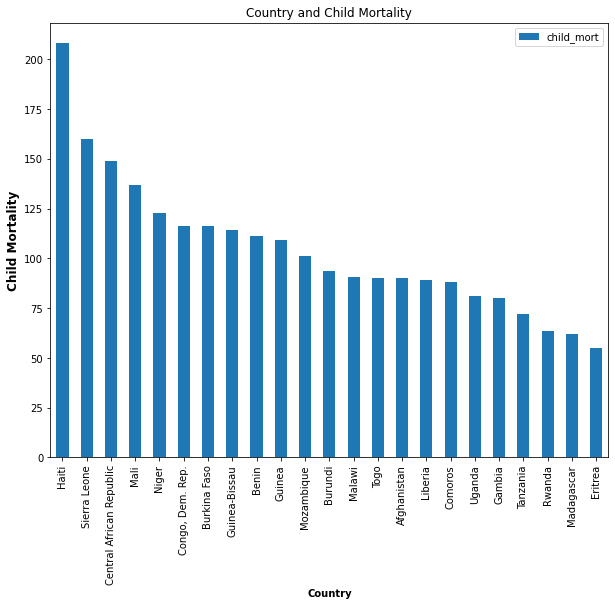

In [161]:
# BarPlot for Child Mortality of countries which are in need of aid

df_list_cm = pd.DataFrame(df_final_list2.groupby(['country'])['child_mort'].mean().sort_values(ascending = False))
df_list_cm.plot.bar()
plt.title('Country and Child Mortality')
plt.xlabel("Country",fontweight = 'bold')
plt.ylabel("Child Mortality", fontsize = 12, fontweight = 'bold')
plt.show()

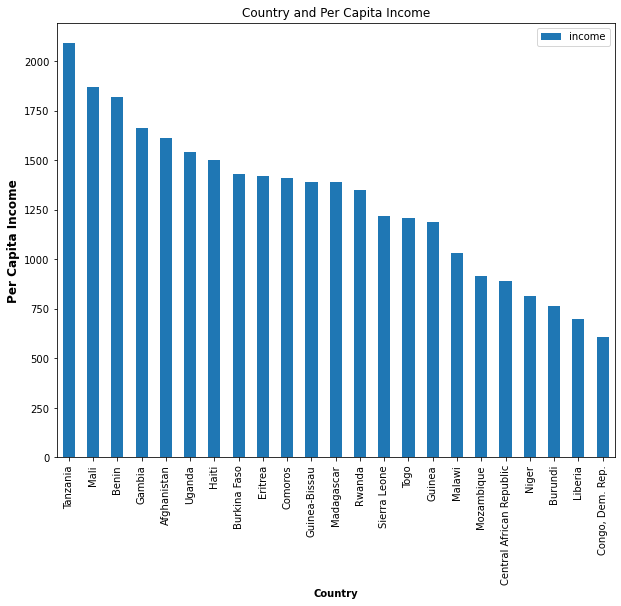

In [162]:
# BarPlot for Per Capita Income of countries which are in need of aid

df_list_in = pd.DataFrame(df_final_list2.groupby(['country'])['income'].mean().sort_values(ascending = False))
df_list_in.plot.bar()
plt.title('Country and Per Capita Income')
plt.xlabel("Country",fontweight = 'bold')
plt.ylabel("Per Capita Income", fontsize = 12, fontweight = 'bold')
plt.show()

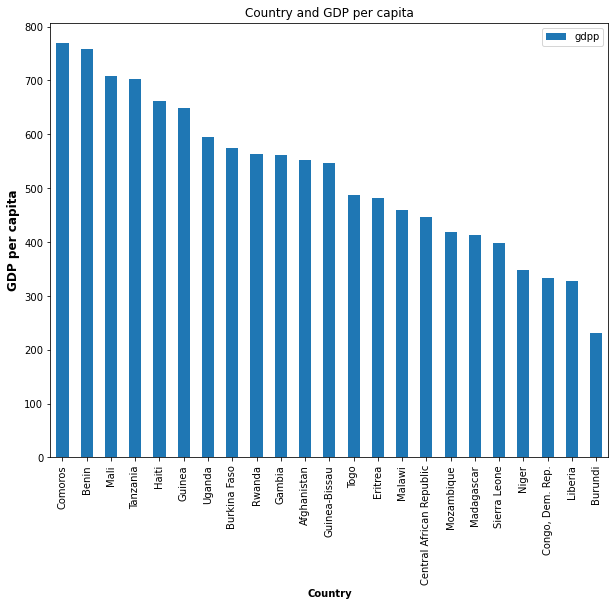

In [163]:
# BarPlot for GDP of countries which are in need of aid

df_list_gdp = pd.DataFrame(df_final_list2.groupby(['country'])['gdpp'].mean().sort_values(ascending = False))
df_list_gdp.plot.bar()
plt.title('Country and GDP per capita')
plt.xlabel("Country",fontweight = 'bold')
plt.ylabel("GDP per capita", fontsize = 12, fontweight = 'bold')
plt.show()

### Closing Statement

We have used PCA above to reduce the variables involved and then done the clustering of countries based on those Principal components
and then later we identified few factors like `child mortality`, `income` etc which plays a vital role in deciding the development status of the country and builded clusters of countries based on that.
Based on those clusters we have identified the below list of countries which are in dire need of aid.
The list of countries are subject to change as it is based on the few factors like `Number of components chosen`,
`Number of Clusters chosen`, `Clustering method used` etc.which we have used to build the model. 

In [164]:
# Final countries list
df_final_list2.reset_index(drop=True).country

0                  Afghanistan
1                        Benin
2                 Burkina Faso
3                      Burundi
4     Central African Republic
5                      Comoros
6             Congo, Dem. Rep.
7                      Eritrea
8                       Gambia
9                       Guinea
10               Guinea-Bissau
11                       Haiti
12                     Liberia
13                  Madagascar
14                      Malawi
15                        Mali
16                  Mozambique
17                       Niger
18                      Rwanda
19                Sierra Leone
20                    Tanzania
21                        Togo
22                      Uganda
Name: country, dtype: object